# <font color = "000080">Redes neurais recorrentes: análise de sentimento com o conjunto de dados do IMDb</font>

Vamos usar o conjunto de dados das críticas de filmes do IMDb (*the Internet Movie Database*) embutido no `Keras` para executar a classificação binária, prevendo se o sentimento de uma determinada crítica é positivo ou negativo.

## <font color = "000080">1. Carregando o conjunto de dados</font>

O conjunto de dados de análises de filmes IMDb incluído no `Keras` contém 25.000 amostras de treinamento e 25.000 amostras de testes, cada uma rotulada com o seu sentimento positivo (1) ou negativo (0).

In [ ]:
# Importar o módulo imdb
from tensorflow.keras.datasets import imdb

A função `load_data` do módulo `imdb` retorna os conjuntos de testes e treinamento. Existem mais de 88.000 palavras únicas no conjunto de dados. A função `load_data` permite especificar o número de palavras exclusivas a serem importadas como parte dos dados de treinamento e teste. Aqui, carregamos apenas as 10.000 palavras mais comuns, devido às limitações de memória do nosso sistema (treinar com CPU e não GPU).

In [ ]:
# Carregar apenas 10.000 palavras
numero_de_palavras = 10000

Utilize a função `load_data()` para carregar o conjunto de dados e retornar as duas tuplas contendo os dados de treinamento e de teste.

In [ ]:
(X_treino, y_treino), (X_teste, y_teste) = imdb.load_data(num_words=numero_de_palavras)

<font color = "000080">A função `load_data()` carrega o conjunto de dados e retorna a tupla com dois elementos cada, contendo os dados de treinamento e de teste.</font>

## <font color = "000080">2. Explorando o conjunto de dados</font>

Observe os dados do conjunto de treinamento, rótulos de teste e suas dimensões:


In [ ]:
X_treino.shape

(25000,)

In [ ]:
X_treino.shape

(25000,)

In [ ]:
X_teste.shape

(25000,)

In [ ]:
X_teste.shape

(25000,)

In [ ]:
# Necessário para o tempo da aula
X_treino = X_treino[::50]
X_teste = X_teste[::50]
y_treino = y_treino[::50]
y_teste = y_teste[::50]

Os *arrays* `y_treino` e `y_teste` são unidimensionais, contendo 1s e 0s, indicando se cada revisão é positiva ou negativa.<br>

Com base nas saídas anteriores, `X_treino` e `X_teste` também parecem ser unidimensionais.

No entanto, seus elementos são na verdade **listas** de números inteiros, cada um representando o conteúdo de uma crítica, como mostrado em `X_treino[123]`, por exemplo.

In [ ]:
%pprint

Pretty printing has been turned OFF


In [ ]:
X_treino[123]

[1, 6, 464, 7, 1923, 16, 11, 4, 177, 17, 6, 2, 1544, 6, 701, 1386, 173, 17, 13, 2283, 29, 839, 12, 120, 23, 288, 38, 13, 100, 67, 12, 12, 16, 221, 21, 55, 76, 421, 40, 35, 2374, 22, 6, 73, 93, 2374, 22, 151, 66, 357, 5, 862, 398, 12, 16, 242, 253, 8, 97, 5, 30, 574, 11, 21, 12, 407, 161, 1833, 101, 243, 7, 1876, 766, 279, 11, 2, 3403, 358, 12, 21, 14, 2642, 250, 16, 1100, 5, 1252, 243, 7, 2942, 18, 61, 5766, 3866, 10, 10, 48, 14, 22, 3011, 47, 93, 42, 166, 101, 53, 108, 29, 66, 144, 353, 8, 28, 6, 66, 221, 65, 347, 5, 52, 156, 146, 252, 14, 16, 6, 87, 2799, 6646, 18, 98, 13, 657, 98, 1996, 11, 4, 705, 5, 440, 36, 70, 4392, 68, 22, 231]

## <font color = "000080">Codificando as críticas</font>

Como as críticas de filmes são codificadas numericamente (já que os modelos `Keras` trabalham com dados numéricos), para visualizar o texto original, é preciso conhecer a palavra à qual cada número corresponde.

O conjunto de dados IMDb de `Keras` fornece um dicionário que mapeia as palavras para os seus índices. O valor correspondente de cada palavra é sua classificação de frequência entre todas as palavras em todo o conjunto de críticas (*reviews*).

Assim, a palavra com a classificação 1 é a palavra que ocorre com mais frequência (calculada pela equipe `Keras` desde o conjunto de dados), a palavra com a classificação 2 é a segunda palavra que ocorre com mais frequência e assim por diante.

Observações:

Embora os valores do dicionário iniciem com 1 como a palavra que ocorre com mais frequência, em cada revisão codificada (como `X_treino[123]` mostrado anteriormente), os valores de classificação são deslocados em 3 unidades.

Portanto, qualquer crítica que contenha a palavra que ocorre com mais frequência terá o valor 4 sempre que essa palavra aparecer na crítica. `Keras` reserva os valores 0, 1 e 2 em cada crítica codificada para os seguintes propósitos:

- O valor 0 em uma crítica representa **preenchimento** (*padding*). Os algoritmos de aprendizado profundo em `Keras` esperam que todas as amostras de treinamento tenham as mesmas dimensões, portanto, algumas críticas podem precisar ser expandidas para um determinado comprimento e outras encurtadas para esse comprimento. As críticas que precisam ser expandidas são preenchidas com 0s.

- O valor 1 representa um *token* que o `Keras` usa internamente para indicar o início de uma sequência de texto para fins de aprendizado.

- O valor 2 em uma crítica representa uma palavra desconhecida: normalmente uma palavra que não foi carregada porque você chamou `load_data` com o argumento `numero_de_palavras`. Nesse caso, qualquer crítica que contenha palavras com classificação de frequência maior que `numero_de_palavras` terá os valores numéricos dessas palavras substituídos por 2. Isso tudo é tratado por `Keras` quando você carrega os dados.

## <font color = "000080">Decodificando as críticas</font>

Com o deslocamento em três unidades na codificação, é preciso tratá-lo na decodificação da crítica.

In [ ]:
# Capturar os índices das palavras com get_word_index
palavra_a_indice = imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
# 'great' deve aparecer bastante (crítica positiva)
palavra_a_indice['superman']

1829

De acordo com a saída, 'great' é a 84a palavra mais frequente do conjunto de dados.
Se procurarmos uma palavra que não está no dicionário, será lançada uma exceção.

Para transformar as classificações de frequência em palavras, primeiro invertemos o mapeamento do dicionário `palavra_a_indice`, para que possamos procurar cada palavra por sua classificação de frequência.

In [ ]:
indice_a_palavra = \
    {indice: palavra for (palavra, indice) in palavra_a_indice.items()}

Vejamos as 50 palavras mais frequentes no dicionário `indice_a_palavra`:

In [ ]:
[indice_a_palavra[i] for i in range(1, 51)]

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there', 'what', 'good', 'more']

Agora, podemos decodificar uma crítica. Usamos o método `get` de dois argumentos do dicionário `indice_a_palavra`, em vez do operador `[]` para obter valor para cada chave. 

Se um valor não estiver no dicionário, o método `get` retornará seu segundo argumento, em vez de gerar uma exceção. O argumento `i - 3` é responsável pelo deslocamento nas críticas codificadas das classificações de frequência de cada crítica.

Quando os valores reservados de `Keras` de 0 a 2 aparecerem em uma crítica, retorna `'?'`; caso contrário, `get` retorna a palavra com a chave `i - 3` no dicionário `indice_a_palavra`.

In [ ]:
' '.join([indice_a_palavra.get(i - 3, '?') for i in X_treino[123]])

"? a friend of mine was in the cast as a ? agent a non speaking part as i recall he brought it over on dvd so i could see it it was interesting but very much felt like an amateur film a well made amateur film though really boring and poorly written it was probably fun to make and be involved in but it definitely didn't deserve any kind of wide release maybe in ? they'd enjoy it but this california girl was bored and honestly kind of embarrassed for my friend's involvement br br if this film maker has made or makes any more films he really should try to have a really interesting story line and good actors i'm sure this was a great learning tool for them i wish them luck in the future and hope they can improve their film making"

In [ ]:
y_treino[123]

0

## <font color = "000080">3. Preparação dos dados</font>

O número de palavras por críticas varia, mas o `Keras` exige que todas as amostras tenham as mesmas dimensões. Portanto, precisamos executar alguma preparação de dados. 

Nesse caso, precisamos restringir cada crítica ao mesmo número de palavras. Algumas revisões precisarão ser preenchidas com dados adicionais e outras precisarão ser truncadas.

A função `pad_sequences` remodela as amostras de `X_treino` (as suas linhas) para o número de atributos especificados pelo argumento `maxlen(200)` e retorna um *array* bidimensional.

In [ ]:
# Atribuir 200 a variável
palavras_por_review = 200

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Utilizar a função pad_sequences para remodelar as amostras em X_treino
X_treino = pad_sequences(X_treino, maxlen= palavras_por_review)

Verificando o novo formato de `X_treino`:

In [ ]:
X_treino.shape

(500, 200)

In [ ]:
# Utilizar novamente a função pad_sequences
X_teste = pad_sequences(X_teste, maxlen= palavras_por_review)

In [ ]:
# Verificar o formato de X_teste
X_teste.shape

(500, 200)

### <font color = "000080">Dividindo o conjunto de dados</font>

Em vez de usar o argumento `validation_split` do método `fit` para indicar qual porcentagem dos nossos dados de treinamento devem ser reservados para validar o modelo enquanto ele treina, dividiremos manualmente as 25.000 amostras de teste em 20.000 amostras e 5.000 amostras de validação.

In [ ]:
from sklearn.model_selection import train_test_split

# Utilizar a função train_test_split
X_teste, X_val, y_teste, y_val = train_test_split(
    X_teste, y_teste, random_state=11, test_size=0.20)

In [ ]:
# Verificar o formato de X_teste
X_teste.shape

(400, 200)

In [ ]:
# Verificar o formato de X_val
X_val.shape

(100, 200)

## <font color = "000080">4. Criando a rede</font>

Com os dados preparados, é hora de criar a rede!<br>Começaremos com o módulo `tensorflow.keras.models` e seu modelo `Sequential`.<br>Assim, criaremos uma rede *feed-forward* a qual sua saída (em uma camada) é entrada para outra camada.

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
rnn = Sequential()

### <font color = "000080">Adicionando camadas</font>

In [ ]:
# Importar as classes Dense e LSTM
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
# Importar a classe Embedding
from tensorflow.keras.layers import Embedding

Nosso modelo vai processar 10.000 palavras únicas, então precisamos de um `array` 10.000x10.000 para representar todas as palavras. São 100.000 elementos os quais, em sua maioria, prenchidos com valor zero. Assim, não compensa usar `one-hot encoding` nesse caso (converter rótulos de inteiros para categóricos).

Se processarmos mais de 88.000 palavras únicas no conjunto de dados total, precisaremos de um `array` de quase oito bilhões de elementos.

Para reduzir a dimensionalidade, as RNNs que processam sequências de texto geralmente começam com uma camada de incorporação (*embedding*) que codifica cada palavra em uma representação de vetor denso mais compacta. Os vetores produzidos pela camada de incorporação também capturam o contexto da palavra, ou seja, como uma determinada palavra se relaciona com as palavras ao seu redor. Portanto, a camada de incorporação permite que a RNN aprenda relacionamentos de palavras entre os dados de treinamento.

In [ ]:
# adicionando camada 'Embedding'
rnn.add(Embedding(input_dim= numero_de_palavras, output_dim=128,
                  input_length= palavras_por_review))

Argumentos de `Embedding`:
- **input_dim**: número de palavras únicas
- **output_dim**: tamanho de cada palavra incorporada
- **input_length**: número de palavras em cada amostra

In [ ]:
# adicionando camada 'LSTM'
rnn.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))

Argumentos de `LSTM`:
- **units**: número de neurônios na camada
- **dropout**: a porcentagem de neurônios que serão desativados aleatoriamente ao processar as entradas e saídas da camada
- **recurrent_dropout**: porcentagem de neurônios que são desativados aleatoriamente quando a saída da camada é inserida novamente na camada para permitir que a rede aprenda com o que viu anteriormente

Agora vamos pegar a saída da camada LSTM e reduzi-la a um resultado, indicando se uma revisão é positiva ou negativa, portanto, o valor 1 para o argumento das unidades.

Usamos a função de ativação `sigmoide`, que é preferida para classificação binária. Ela reduz valores arbitrários no intervalo de 0 a 1, produzindo uma probabilidade.

In [ ]:
rnn.add(Dense(units=1, activation='sigmoid'))

### <font color = "000080">Finalizando o modelo.</font>

Agora falta completar o modelo da rede chamando o método `compile`.<br>
Utilizaremos a otimização `adam`, que é um método de descida de gradiente estocástico, baseado na estimativa adaptativa de momentos de primeira e segunda ordem.<br>
Para cálculo da taxa de erro, usaremos `binary_crossentropy` já que temos duas possíveis saídas.<br>
Em `metrics`, usamos `accuracy` que simplesmente calcula com que frequência as previsões são iguais aos rótulos.

In [ ]:
rnn.compile(optimizer='adam',
            loss='binary_crossentropy', 
            metrics=['accuracy'])

A seguir, um resumo do nosso modelo.

O grande número de parâmetros treináveis vem principalmente do número de palavras no vocabulário (carregamos 10.000) vezes o número de neurônios na saída da camada de incorporação (128).

In [ ]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


## <font color = "000080">5. Treinando o modelo</font>

Após decidirmos a arquitetura do modelo (número de camadas ocultas, funções de ativação etc), a fase de compilação, agora vamos a próxima fase: treinamento.<br>
O método `fit` recebe nos dois primeiros argumentos o conjunto de treinamento e o objetivo (*target*).<br>
`epochs` indica o número de épocas de treinamento.<br>
`batch_size` indica o número de amostras para processar a cada época. Geralmente potências de 2, desde 32 a 512.<br>
`validation_data` para especificar uma tupla contendo *arrays* de amostras e rótulos de destino.

In [ ]:
historico = rnn.fit(X_treino, y_treino, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
16/16 [==============================] - 18s 806ms/step - loss: 0.6921 - accuracy: 0.5340 - val_loss: 0.6898 - val_accuracy: 0.5800
Epoch 2/5
16/16 [==============================] - 12s 779ms/step - loss: 0.6488 - accuracy: 0.6900 - val_loss: 0.6594 - val_accuracy: 0.6200
Epoch 3/5
16/16 [==============================] - 12s 767ms/step - loss: 0.5863 - accuracy: 0.7940 - val_loss: 0.6481 - val_accuracy: 0.5900
Epoch 4/5
16/16 [==============================] - 12s 766ms/step - loss: 0.4158 - accuracy: 0.8840 - val_loss: 0.6950 - val_accuracy: 0.5900
Epoch 5/5
16/16 [==============================] - 12s 772ms/step - loss: 0.1967 - accuracy: 0.9560 - val_loss: 0.8145 - val_accuracy: 0.6300


In [ ]:
# avaliar os resultados com evaluate
resultados = rnn.evaluate(X_teste, y_teste)

13/13 [==============================] - 1s 54ms/step - loss: 0.7212 - accuracy: 0.6325


In [ ]:
resultados

[0.7211742997169495, 0.6324999928474426]

In [ ]:
# avaliar os resultados com evaluate e retornar a tupla (erro, acuracia)
# para os gráficos
erro, acuracia = rnn.evaluate(X_teste, y_teste)

13/13 [==============================] - 1s 56ms/step - loss: 0.7212 - accuracy: 0.6325


In [ ]:
# Capturar os rótulos do treinamento: 'loss', 'accuracy', 'val_loss' e 'val_accuracy'
# para plotar os gráficos de acurácia e perdas
hist_dicio = historico.history
hist_dicio.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

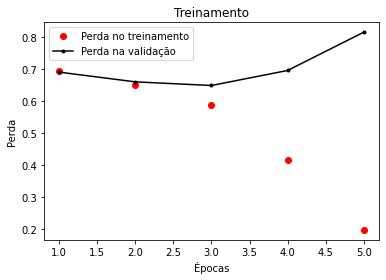

In [ ]:
# plotar o gráfico de perdas de treinamento e validação
# epocas vs loss ; epocas vs val_loss
import matplotlib.pyplot as plt

acc = hist_dicio['accuracy']
val_acc = hist_dicio['val_accuracy']
loss = hist_dicio['loss']
val_loss = hist_dicio['val_loss']

epocas = range(1,len(acc)+1)

plt.plot(epocas,loss,'ro',label="Perda no treinamento")
plt.plot(epocas,val_loss, 'k.-', label="Perda na validação")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.title("Treinamento")
plt.legend()
plt.show()

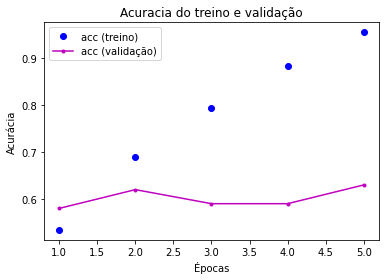

In [ ]:
# plotar o gráfico de acurácia de treinamento e validação
# epocas vs accuracy ; epocas vs val_accuracy
plt.clf()

plt.plot(epocas, acc, 'bo', label = "acc (treino)")
plt.plot(epocas, val_acc, 'm.-' , label = "acc (validação)")
plt.title("Acuracia do treino e validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

## <font color = "000080">Considerações finais</font>

Apresentamos redes neurais recorrentes (RNNs) para processar texto em frases.
Usamos uma RNN com o conjunto de dados de resenhas de filmes da IMDb para realizar a classificação binária, prevendo se o sentimento de cada resenha era positivo ou negativo.

## <font color = "000080">Referências</font>

DEITEL, P. e DEITEL, H., Intro to Python for computer science and data science. Pearson, 2020.

In [ ]:
# Adaptado de:
#
##########################################################################
# (C) Copyright 2019 by Deitel & Associates, Inc. and                    #
# Pearson Education, Inc. All Rights Reserved.                           #
#                                                                        #
# DISCLAIMER: The authors and publisher of this book have used their     #
# best efforts in preparing the book. These efforts include the          #
# development, research, and testing of the theories and programs        #
# to determine their effectiveness. The authors and publisher make       #
# no warranty of any kind, expressed or implied, with regard to these    #
# programs or to the documentation contained in these books. The authors #
# and publisher shall not be liable in any event for incidental or       #
# consequential damages in connection with, or arising out of, the       #
# furnishing, performance, or use of these programs.                     #
##########################################################################